## Observations
* The predictive mean of the multi-output surrogate is incorrect when we consider a new function and gradient observation. The predictive mean is incorrect, so the issue is with the covariance matrix, the learned coefficients or the covariance matrix associated with the new observation and it's partials.
* Check the computations for my kernels when computing the covariance matrices

In [1]:
using LinearAlgebra
using Plots

In [2]:
include("../rollout.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

In [3]:
BUDGET = 1

1

In [4]:
testfn = TestFunction(
    1,
    [-15. 15.],
    [0.],
    x -> (sin(first(x)) * first(x)^2) / 200,
    x -> [sin(first(x)) * 2first(x) + cos(first(x))*first(x)^2]
)

TestFunction(1, [-15.0 15.0], [0.0], var"#696#698"(), var"#697#699"())

In [5]:
MAX_BUDGET, MAX_TRIALS = 2, 1
n, h, σn2 = 2, 1, 1e-6
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [10.]
ψ = kernel_matern52(θ)
sur = nothing
fsur = nothing

@time begin
for trial in 1:MAX_TRIALS
    # Initialize sample
    X = rand(1, n)
    δX = rand(size(X)...)
    y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
    ∇y = [testfn.∇f(X[:,j]) for j in 1:size(X, 2)]
    sur = fit_surrogate(ψ, X, y; σn2=σn2)

    println("$trial.)Executing Main Loop for Rollout Bayesian Optimization")
    for budget in 1:MAX_BUDGET
        fsur = fit_fsurrogate(sur, h)
        δsur = fit_δsurrogate(fsur, δX, ∇y)
        mfsur = fit_multioutput_fsurrogate(sur, h)

        # Rollout/Trajectory Simulation
        for trajectory_step in 1:h+1
            xnew = rand(xmin:.01:xmax, d)
            δxnew = rand(d)
            ynew = testfn.f(xnew)
            ∇ynew = testfn.∇f(xnew)
            y = vcat(y, ynew)
            y = vcat(y, ∇ynew)
            update_fsurrogate!(fsur, xnew, ynew)
            update_δsurrogate!(δsur, fsur, δxnew, ∇ynew)
            update_multioutput_fsurrogate!(mfsur, xnew, ynew, ∇ynew)
        end

        xnew = rand(xmin:.01:xmax, d)
        ynew = testfn.f(xnew)
        ∇ynew = testfn.∇f(xnew)
        δX = hcat(δX, rand(d, 1))
        X = hcat(X, xnew)
        y = vcat(y, ynew)
        push!(∇y, ∇ynew)
        sur = update_surrogate(sur, xnew, ynew)
    end
end
println()
end

1.)Executing Main Loop for Rollout Bayesian Optimization

  5.985560 seconds (18.46 M allocations: 930.155 MiB, 2.47% gc time, 99.28% compilation time)


In [9]:
xstarts = rand(xmin:.01:xmax, 1, 30)
multistart_ei_solve(fsur, [xmin], [xmax], xstarts)

1-element Vector{Float64}:
 -14.999999999999899

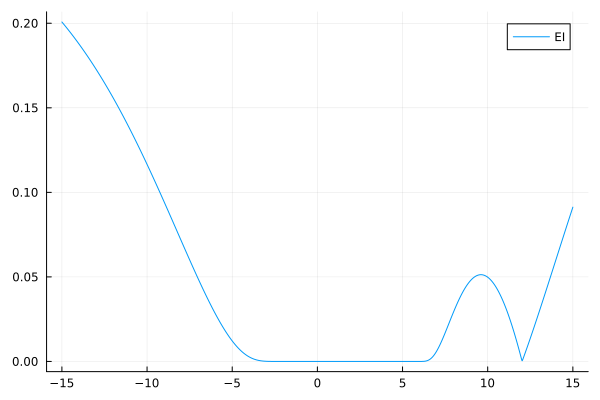

In [8]:
domain = xmin:.01:xmax
plot(domain, [fsur([x]).EI for x in domain], label="EI")

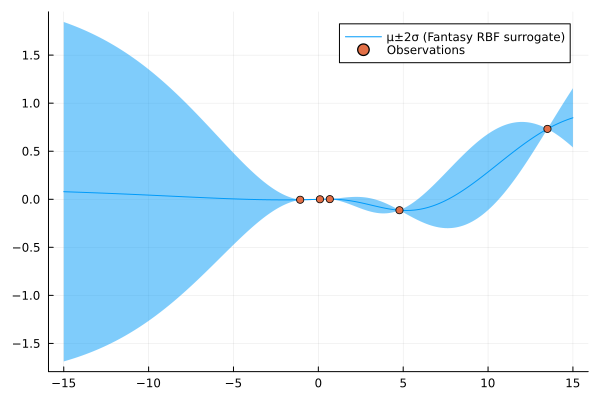

In [32]:
p = plot1D(fsur; xmin=xmin, xmax=xmax, npts=1000)

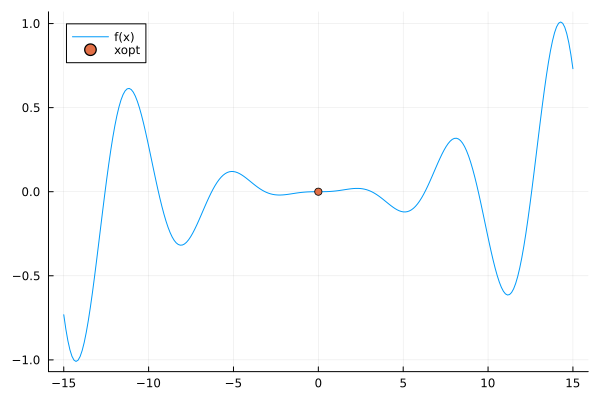

In [33]:
tplot(testfn)

In [ ]:
plot1